In [4]:
#pip install Catboost

In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
from typing import Any, Tuple
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import torch
from xgboost import XGBRanker
import seaborn as sns
from catboost import CatBoostClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV

   - Столбец '0' - целое число (0-4), отражающее релевантность документа запросу.
      - 0: Неактуально
      - 4: идеально релевантный
    - Колонка '1' имеет форму 'qid:int', идентифицирующую запрос.
    - Столбцы '2' - '137' содержат признаки для пары запрос-документ в форме 'feature_id:feature_value'.
    - Обучающий набор используется для обучения моделей ранжирования. Валидационный набор используется для настройки гиперпараметров алгоритмов обучения. Тестовый набор используется для оценки эффективности полученных моделей ранжирования.
    - https://www.microsoft.com/en-us/research/project/mslr/

In [29]:
def data_loader(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_df = pd.read_csv(train_path, header=None, sep=" ")
    test_df = pd.read_csv(test_path, header=None, sep=" ")

    return train_df, test_df

train_df, test_df = data_loader("train-2.txt",
                                "test.txt")

In [30]:
train_df.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
29493,1,qid:7273,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,...,128:73,129:4,130:16183,131:57988,132:4,133:1,134:0,135:0,136:0,NaN
23535,0,qid:6493,1:2,2:0,3:2,4:2,5:2,6:1,7:0,8:1,...,128:8,129:2,130:1533,131:38595,132:28,133:17,134:0,135:0,136:0,NaN
1046,1,qid:3748,1:1,2:0,3:1,4:1,5:1,6:1,7:0,8:1,...,128:0,129:0,130:44661,131:9612,132:17,133:113,134:0,135:0,136:0,NaN


In [31]:
test_df.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
2504,0,qid:298,1:2,2:0,3:2,4:0,5:2,6:1,7:0,8:1,...,128:0,129:31,130:5909,131:63583,132:5,133:1,134:0,135:0,136:0,NaN
3075,0,qid:403,1:2,2:0,3:1,4:0,5:2,6:1,7:0,8:0.50000,...,128:10,129:0,130:144,131:172,132:2,133:10,134:0,135:0,136:0,NaN
5302,0,qid:658,1:1,2:0,3:0,4:0,5:1,6:1,7:0,8:0,...,128:0,129:0,130:63043,131:43881,132:2,133:4,134:0,135:0,136:0,NaN


## Подготовка данных

Для начала поправим данные в столбцах. Сейчас значения в таблице выглядит как "номер/название столбца: значение фичи"

In [32]:

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
  df[1] = df[1].apply(lambda x: x[4:]) #убираем qiв: в первом столбце
  df.iloc[:, 2:138] = df.iloc[:, 2:138].applymap(lambda x: x.split(':')[1] if isinstance(x, str) and ':' in x else x)
 #в столбцах с индексами от 2 до 137, каждый элемент разбивается по символу ":", и берется вторая часть (после ":", если она есть)
  df.columns = ['feat_' + str(i-1) for i in df.columns] #переименуем столбцы
  df.rename(columns={'feat_-1': 'y', 'feat_0': 'qid'}, inplace=True)

  return df

In [33]:
processed_train_df = preprocess_data(train_df).astype(float)
processed_test_df = preprocess_data(test_df).astype(float)


processed_train_df.sample(3)

<ipython-input-32-cdb01cc77f73>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 2:138] = df.iloc[:, 2:138].applymap(lambda x: x.split(':')[1] if isinstance(x, str) and ':' in x else x)
<ipython-input-32-cdb01cc77f73>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 2:138] = df.iloc[:, 2:138].applymap(lambda x: x.split(':')[1] if isinstance(x, str) and ':' in x else x)


,y,qid,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_128,feat_129,feat_130,feat_131,feat_132,feat_133,feat_134,feat_135,feat_136,feat_137
20020,1.0,5953.0,3.0,0.0,2.0,3.0,3.0,1.0,0.0,0.666667,...,13.0,8.0,47371.0,12913.0,40.0,6.0,0.0,0.0,0.00000,NaN
24847,0.0,6673.0,1.0,0.0,1.0,0.0,1.0,0.5,0.0,0.500000,...,2653.0,15.0,20510.0,65535.0,1.0,8.0,0.0,0.0,0.00000,NaN
4525,0.0,3853.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.000000,...,902.0,3.0,8109.0,24094.0,143.0,142.0,0.0,126.0,30.34825,NaN


In [34]:
processed_train_df.describe()

,y,qid,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_128,feat_129,feat_130,feat_131,feat_132,feat_133,feat_134,feat_135,feat_136,feat_137
count,29650.000000,29650.000000,29650.000000,29650.000000,29650.000000,29650.000000,29650.000000,29650.000000,29650.000000,29650.000000,...,2.964800e+04,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,2.964800e+04,2.964800e+04,0.0
mean,0.620776,5293.152277,1.913423,0.207285,1.178111,0.514604,1.948735,0.804796,0.098691,0.534472,...,1.235736e+05,3.885119,19410.565569,33690.875675,16.863600,26.214686,41.894462,3.075098e+02,4.453348e+04,NaN
std,0.813019,1135.828699,1.161672,0.567363,1.020158,0.776136,1.132434,0.338908,0.264228,0.421234,...,3.700388e+06,8.210927,21919.087118,21239.182349,29.085237,43.387491,1807.373447,1.546222e+04,5.436216e+06,NaN
min,0.000000,3613.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,115.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,NaN
25%,0.000000,4273.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000e+00,0.000000,1283.750000,13904.750000,2.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,NaN
50%,0.000000,5233.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.500000,...,4.000000e+00,0.000000,8670.000000,34644.000000,6.000000,7.000000,0.000000,0.000000e+00,0.000000e+00,NaN
75%,1.000000,6298.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,6.000000e+01,4.000000,34851.750000,53262.000000,17.000000,25.000000,0.000000,1.000000e+00,8.000000e-01,NaN
max,4.000000,7288.000000,9.000000,6.000000,9.000000,6.000000,9.000000,1.000000,1.000000,1.000000,...,2.262445e+08,139.000000,65534.000000,65535.000000,254.000000,250.000000,196691.000000,1.731553e+06,7.100000e+08,NaN


137 фича неинформативна, удаляем её из дф

In [35]:
processed_train_df = processed_train_df.drop(columns=['feat_137'])
processed_test_df = processed_test_df.drop(columns=['feat_137'])

Проверим, где ещё есть NA, удалим строки, содержащие NA

In [36]:
processed_train_df.isna().sum()

,0
y,0
qid,0
feat_1,0
feat_2,0
feat_3,0
...,...
feat_132,2
feat_133,2
feat_134,2
feat_135,2


In [37]:
processed_train_df.dropna(inplace=True)

In [44]:
processed_test_df.dropna(inplace=True)

In [38]:
# Разделение данных на фичи (X) и целевую переменную (y)
X = processed_train_df.drop(columns=['y','qid'])
y = processed_train_df['y']

# Разделение на тренировочную и тестовую выборки
X = np.log(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Шаг 2: Обучение CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    verbose=False,
    random_state=42
)

model.fit(X_train, y_train)

# Шаг 3: Получение важности признаков
feature_importances = model.get_feature_importance(prettified=True)
print("Feature Importances:")
print(feature_importances)


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Feature Importances:
    Feature Id  Importances
0     feat_130     5.449335
1     feat_131     4.974888
2     feat_133     3.625753
3     feat_128     3.618154
4     feat_127     3.412162
..         ...          ...
131   feat_121     0.000000
132   feat_122     0.000000
133   feat_123     0.000000
134   feat_124     0.000000
135   feat_125     0.000000

[136 rows x 2 columns]


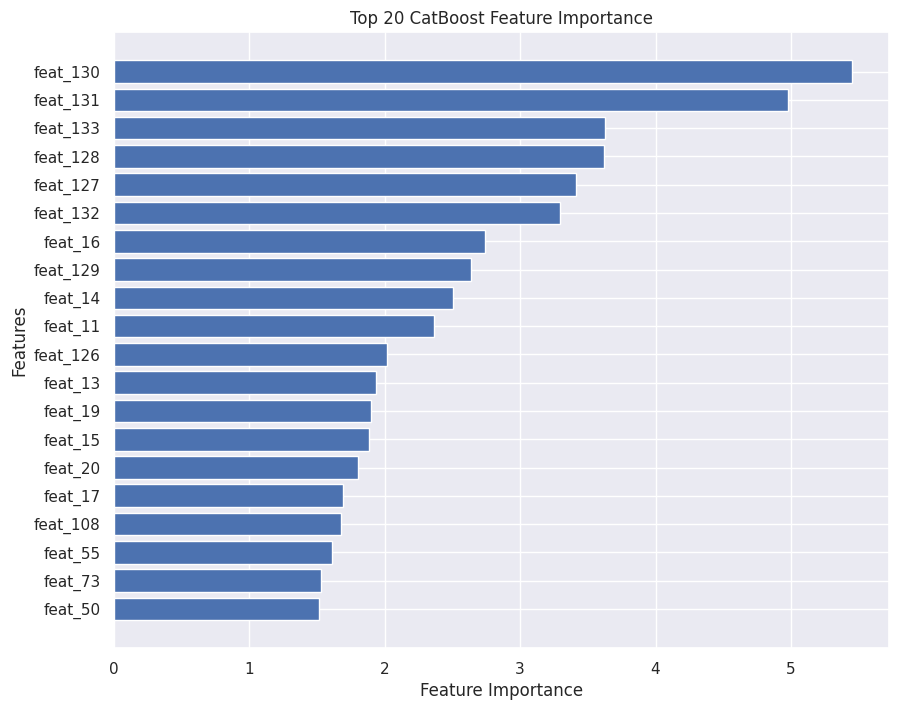

In [39]:
top_20_features = feature_importances.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature Id'], top_20_features['Importances'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [40]:
processed_train_df_main = processed_train_df[top_20_features['Feature Id']]

In [45]:
def histmaker_for_numeric_df(data_train, bins=20, figsize=(15, 5), palette='deep'):
    numeric_df = data_train.select_dtypes(include=np.number)

    sns.set(style='darkgrid', palette=palette)

    num_plots = len(numeric_df.columns)  # количество графиков
    num_rows = (num_plots - 1) // 3 + 1  # количество строк
    num_cols = min(num_plots, 3)         # количество столбцов

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0], figsize[1] * num_rows))
    plt.suptitle('Гистограммы каждой фичи', fontsize=15)

    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < num_plots:
            ax.hist(numeric_df.iloc[:, i], bins=bins, edgecolor='black', alpha=0.7)
            ax.set_title(numeric_df.columns[i], weight='bold')
            if i % 3 == 0:
                ax.set_ylabel('Count')
    for ax in axes[num_plots:]:
        ax.remove()

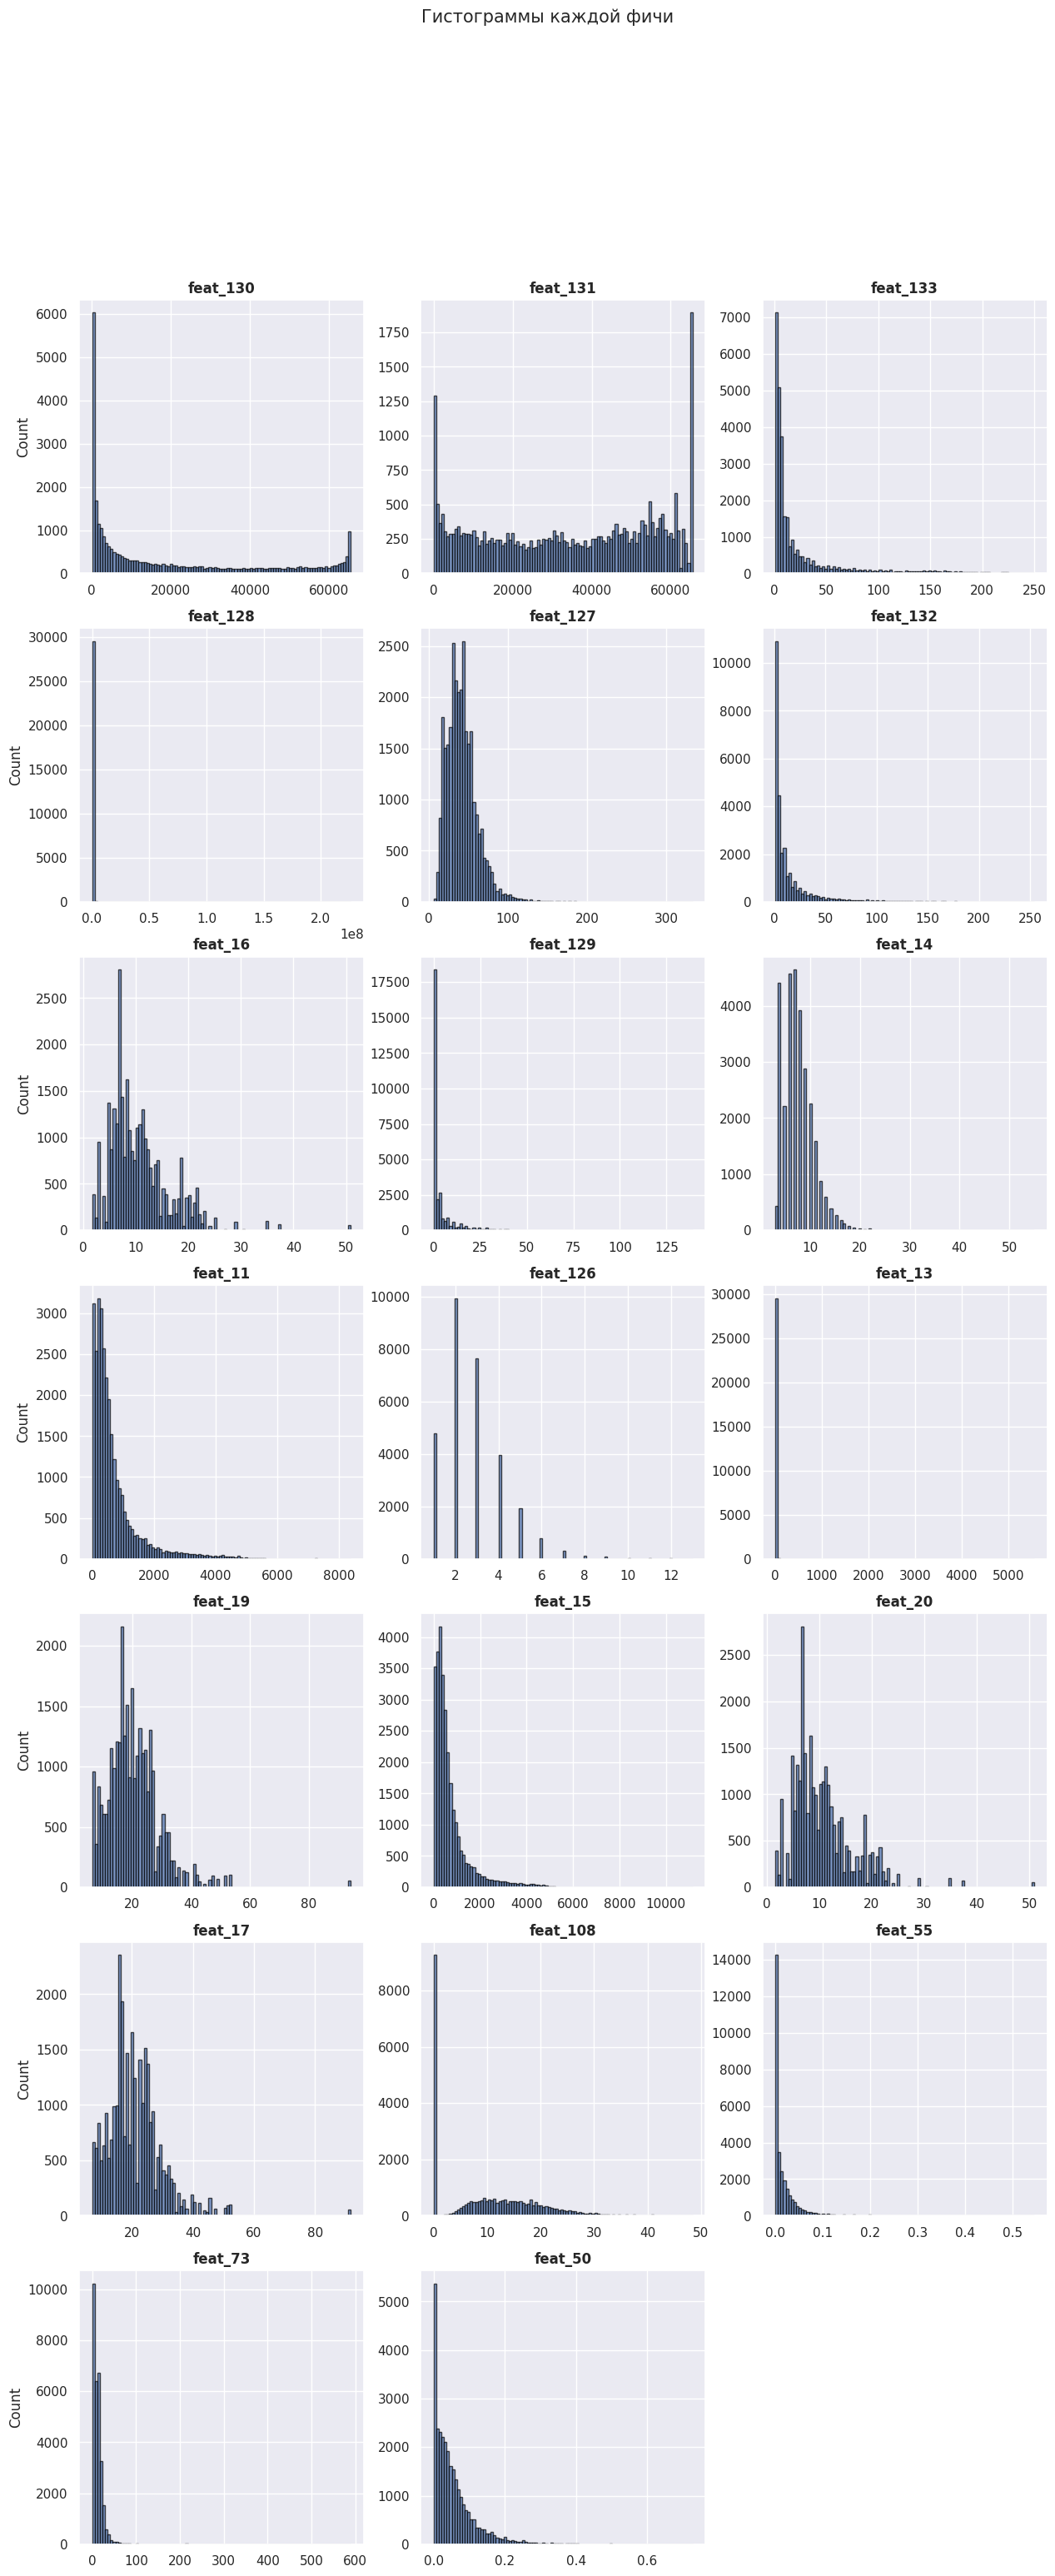

In [46]:
histmaker_for_numeric_df(processed_train_df_main , bins = 100)

In [47]:
processed_train_df_main.describe()

,feat_130,feat_131,feat_133,feat_128,feat_127,feat_132,feat_16,feat_129,feat_14,feat_11,feat_126,feat_13,feat_19,feat_15,feat_20,feat_17,feat_108,feat_55,feat_73,feat_50
count,29648.000000,29648.000000,29648.000000,2.964800e+04,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000,29648.000000
mean,19410.565569,33690.875675,26.214686,1.235736e+05,41.678090,16.863600,10.589922,3.885119,7.615286,691.741905,2.778906,7.689861,20.282867,708.754115,10.579889,20.807153,10.302081,0.017919,11.266545,0.055058
std,21919.087118,21239.182349,43.387491,3.700388e+06,19.721507,29.085237,5.712884,8.210927,3.049219,812.530736,1.431798,33.871453,8.769932,815.747923,5.711068,8.694249,9.056841,0.031747,13.916360,0.060239
min,115.000000,1.000000,1.000000,0.000000e+00,6.000000,1.000000,1.675520,0.000000,3.000000,0.000000,1.000000,0.000000,6.362260,3.000000,1.674509,6.974810,0.000000,0.000000,0.000000,0.000000
25%,1283.750000,13904.750000,4.000000,0.000000e+00,28.000000,2.000000,6.775396,0.000000,6.000000,214.000000,2.000000,4.000000,14.651497,229.000000,6.771757,15.466806,0.000000,0.000000,0.000000,0.013412
50%,8670.000000,34644.000000,7.000000,4.000000e+00,39.000000,6.000000,9.234433,0.000000,7.000000,431.000000,3.000000,6.000000,19.462179,447.000000,9.203960,19.933365,9.884411,0.006216,9.848379,0.037864
75%,34851.750000,53262.000000,25.000000,6.000000e+01,51.000000,17.000000,13.169067,4.000000,9.000000,826.000000,3.000000,9.000000,24.723017,845.000000,13.167290,25.363399,16.821151,0.022346,16.480670,0.075155
max,65534.000000,65535.000000,250.000000,2.262445e+08,333.000000,254.000000,50.925900,139.000000,55.000000,8381.000000,13.000000,5558.000000,94.238378,11144.000000,50.902733,91.769956,48.402833,0.545455,589.565086,0.727273


In [48]:
df_train_final = pd.merge(processed_train_df_main, processed_train_df[['y', 'qid']], left_index=True, right_index=True)

In [49]:
df_test_final = pd.merge(processed_test_df[top_20_features['Feature Id']], processed_test_df[['y', 'qid']], left_index=True, right_index=True)

##Pointwise

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, ndcg_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def train_logistic_baseline(df: pd.DataFrame):
    """
    Бейзлайн модель на основе логистической регрессии с многоклассовой поддержкой и масштабированием данных.
    """
    query_col = "qid"
    target_col = "y"
    feature_cols = [col for col in df.columns if col not in [target_col, query_col]]
    X = df[feature_cols]
    y = df[target_col]

    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=df[query_col]
    )

    # Масштабирование данных
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Обучение логистической регрессии
    model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
    model.fit(X_train, y_train)

    # Предсказания вероятностей для всех классов
    y_pred_proba = model.predict_proba(X_test)

    # Оценка модели
    logloss = log_loss(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Для NDCG нужно учитывать вероятности для каждого класса
    ndcg_1 = ndcg_score([y_test.values], [y_pred_proba[:, 1]], k=10)
    ndcg_2 = ndcg_score([y_test.values], [y_pred_proba[:, 1]], k=5)


    print(f"NDCG@10: {ndcg_1:.4f}")
    print(f"NDCG@5: {ndcg_2:.4f}")

    return model

# Запуск обучения
logistic_baseline_model = train_logistic_baseline(processed_train_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NDCG@10: 0.1284
NDCG@5: 0.0365


In [51]:
df_test_final

,feat_130,feat_131,feat_133,feat_128,feat_127,feat_132,feat_16,feat_129,feat_14,feat_11,...,feat_19,feat_15,feat_20,feat_17,feat_108,feat_55,feat_73,feat_50,y,qid
0,266.0,25070.0,7.0,1.0,35.0,28.0,6.553125,0.0,7.0,31.0,...,14.369216,49.0,6.550869,15.011174,10.183562,0.061224,12.950828,0.142857,2.0,13.0
1,153.0,12860.0,158.0,93.0,17.0,65.0,6.553125,0.0,4.0,152.0,...,14.369216,168.0,6.550869,15.011174,0.000000,0.011905,0.000000,0.029762,1.0,13.0
2,153.0,1131.0,141.0,0.0,19.0,112.0,6.553125,0.0,4.0,63.0,...,14.369216,75.0,6.550869,15.011174,5.883981,0.013333,6.129836,0.186667,3.0,13.0
3,560.0,61224.0,14.0,81775.0,50.0,1.0,6.553125,0.0,9.0,4238.0,...,14.369216,4249.0,6.550869,15.011174,22.257080,0.003060,12.950828,0.009179,1.0,13.0
4,57953.0,15600.0,12.0,0.0,24.0,15.0,6.553125,0.0,4.0,183.0,...,14.369216,189.0,6.550869,15.011174,0.000000,0.000000,0.000000,0.005291,0.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26831,1315.0,14084.0,10.0,19.0,29.0,23.0,12.245059,17.0,6.0,251.0,...,21.285093,269.0,12.241706,21.500642,8.857160,0.007435,10.585076,0.066914,0.0,3598.0
26832,166.0,65535.0,2.0,0.0,34.0,3.0,10.203046,1.0,6.0,626.0,...,30.566600,636.0,10.199296,29.313664,10.140824,0.003145,7.455307,0.045597,0.0,3613.0
26833,266.0,11490.0,35.0,20.0,40.0,3.0,10.203046,0.0,9.0,1142.0,...,30.566600,1153.0,10.199296,29.313664,0.000000,0.000867,0.000000,0.007806,0.0,3613.0
26834,199.0,16074.0,3.0,2.0,56.0,1.0,10.203046,2.0,9.0,342.0,...,30.566600,361.0,10.199296,29.313664,22.813380,0.008310,27.263972,0.055402,0.0,3613.0


In [52]:
train_logistic_baseline(df_test_final)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NDCG@10: 0.1748
NDCG@5: 0.1593


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

##Pairwise

In [65]:
from catboost import CatBoostRanker, Pool
from sklearn.model_selection import train_test_split

def train_catboost_ranker(df):
    """
    Функция для обучения модели CatBoostRanker с использованием pairwise ранжирования и внутренней метрики NDCG.

    Parameters:
    - df: pd.DataFrame - исходный датафрейм с данными.

    Returns:
    - model: обученная модель CatBoostRanker
    """
    # Сортировка по qid
    df = df.sort_values(by='qid').reset_index(drop=True)

    # Объявляем переменные
    query_col = "qid"  # Колонка с идентификатором запроса
    target_col = "y"   # Колонка с целевой переменной
    non_features = ['qid', 'y']

    # Подготовка данных
    df['qid'] = df['qid'].astype(int)
    feature_cols = [col for col in df.columns if col not in [query_col, target_col]]
    X = df[feature_cols]
    y = df[target_col]
    group_id = df[query_col]

    # Разделение на train и test
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        X, y, group_id, test_size=0.2, random_state=42, shuffle=False
    )

    # Создание Pool с group_id для pairwise ранжирования
    train_pool = Pool(data=X_train, label=y_train, group_id=group_train)
    test_pool = Pool(data=X_test, label=y_test, group_id=group_test)

    # Создание и обучение модели с pairwise loss
    model = CatBoostRanker(
        iterations=2000,
        learning_rate=0.01,
        depth=4,
        loss_function='YetiRankPairwise',  # Используем pairwise ранжирование
        custom_metric=['NDCG'],  # Внутренняя метрика NDCG
        random_seed=42,
        metric_period=250
    )

    model.fit(train_pool, eval_set=test_pool, verbose=True, plot=True)

    return model

model = train_catboost_ranker(df_train_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6048933	best: 0.6048933 (0)	total: 229ms	remaining: 7m 36s
250:	test: 0.7221413	best: 0.7221413 (250)	total: 32.9s	remaining: 3m 49s
500:	test: 0.7261211	best: 0.7261211 (500)	total: 1m 6s	remaining: 3m 17s
750:	test: 0.7304169	best: 0.7304169 (750)	total: 1m 38s	remaining: 2m 44s
1000:	test: 0.7333793	best: 0.7333793 (1000)	total: 2m 14s	remaining: 2m 13s
1250:	test: 0.7358868	best: 0.7358868 (1250)	total: 2m 46s	remaining: 1m 39s
1500:	test: 0.7374042	best: 0.7374042 (1500)	total: 3m 19s	remaining: 1m 6s
1750:	test: 0.7376830	best: 0.7376830 (1750)	total: 3m 53s	remaining: 33.2s
1999:	test: 0.7377738	best: 0.7377738 (1999)	total: 4m 26s	remaining: 0us

bestTest = 0.7377737688
bestIteration = 1999



In [68]:
X_test = df_test_final.drop(columns=['y', 'qid'])
y_test = df_test_final['y']
def ndcg_at_k(model: Any, x_test: pd.DataFrame, y_test: pd.Series, model_type: str) -> None:
    # Функция для вычисления NDCG@
    y_pred = model.predict(df_test_final)
    ndcg_scores = {
        "NDCG Score": ndcg_score([y_test], [y_pred]),
        "NDCG@5 Score": ndcg_score([y_test], [y_pred], k=5),
        "NDCG@10 Score": ndcg_score([y_test], [y_pred], k=10),
        "NDCG@20 Score": ndcg_score([y_test], [y_pred], k=20),
    }
    print("-" * 50)
    for score_name, score_value in ndcg_scores.items():
        print(f"{model_type} {score_name}: {score_value:.4f}")



In [69]:
ndcg_at_k(model, X_test, y_test, "CatBoost Pairwise Ranker Model")

--------------------------------------------------
CatBoost Pairwise Ranker Model NDCG Score: 0.9066
CatBoost Pairwise Ranker Model NDCG@5 Score: 0.7883
CatBoost Pairwise Ranker Model NDCG@10 Score: 0.7747
CatBoost Pairwise Ranker Model NDCG@20 Score: 0.6443


In [55]:
def get_features_and_labels(df: pd.DataFrame):
    # df содержит признаки и целевые значения.
    X = df.drop(columns=['y', 'qid'])
    y = df['y']
    return X, y

def get_group_counts(query_ids):
    # Возвращает количество элементов в каждой группе (по идентификатору запроса)
    return query_ids.value_counts().sort_index().tolist()

def train_ndcg_boost(df: pd.DataFrame) -> Any:
    query_col = "qid"

    # Получаем X, y и query_ids
    X, y = get_features_and_labels(df)
    query_ids = df[query_col]

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test, query_train, query_test = train_test_split(
        X, y, query_ids, test_size=0.2, random_state=42, stratify=query_ids
    )

    # Получаем количество образцов в каждой группе
    group_train = get_group_counts(query_train)
    group_test = get_group_counts(query_test)

    # Обучаем модель XGBoost с пользовательской функцией потерь NDCG
    xgbranker = xgb.XGBRanker(
        n_estimators=1000,
        learning_rate=0.1,
        objective="rank:pairwise",
        reg_lambda=0.05,
        early_stopping_rounds=100,
        tree_method="hist"
    )

    # Обучение модели
    xgbranker.fit(
        X_train,
        y_train,
        group=group_train,
        eval_group=[group_test],
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    return xgbranker
def ndcg_at_k(model: Any, x_test: pd.DataFrame, y_test: pd.Series, model_type: str) -> None:
    # Функция для вычисления NDCG@
    y_pred = model.predict(x_test)
    ndcg_scores = {
        "NDCG Score": ndcg_score([y_test], [y_pred]),
        "NDCG@5 Score": ndcg_score([y_test], [y_pred], k=5),
        "NDCG@10 Score": ndcg_score([y_test], [y_pred], k=10),
        "NDCG@20 Score": ndcg_score([y_test], [y_pred], k=20),
    }
    print("-" * 50)
    print(y_pred)
    for score_name, score_value in ndcg_scores.items():
        print(f"{model_type} {score_name}: {score_value:.4f}")

In [56]:
X_test = df_test_final.drop(columns=['y', 'qid'])
y_test = df_test_final['y']
model_1 = train_ndcg_boost(df_train_final)

ndcg_at_k(model_1, X_test, y_test, "XGBoost Pairwise Ranker Model")

--------------------------------------------------
[-0.44548655 -0.7914354  -0.9548431  ... -3.1202648  -0.8424278
 -0.85919607]
XGBoost Pairwise Ranker Model NDCG Score: 0.9010
XGBoost Pairwise Ranker Model NDCG@5 Score: 0.4741
XGBoost Pairwise Ranker Model NDCG@10 Score: 0.4877
XGBoost Pairwise Ranker Model NDCG@20 Score: 0.5352


##Нейронка

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

# Dataset для PyTorch
class RankDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Определение модели DLCM на PyTorch
class DLCM(nn.Module):
    def __init__(self, input_dim):
        super(DLCM, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.15)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.15)
        )

        self.layer4 = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.15)
        )

        self.output_layer = nn.Linear(64, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return self.output_layer(x)

# Функция обучения
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=10):
    epoch_train_loss = []
    epoch_val_loss = []

    bar = tqdm(range(num_epochs), desc="Training Progress", leave=True)
    for epoch in bar:
        model.train()
        total_loss = 0
        for batch_idx, (features, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_train_loss.append(total_loss / len(train_loader))

        scheduler.step()  # Обновляем learning rate

        # Валидация
        model.eval()
        val_total_loss = 0
        with torch.no_grad():
            for batch_idx, (features, labels) in enumerate(val_loader):
                outputs = model(features).squeeze()
                loss = criterion(outputs, labels)
                val_total_loss += loss.item()


        epoch_val_loss.append(val_total_loss / len(val_loader))

        bar.set_postfix({
            "Train Loss": f"{epoch_train_loss[-1]:.4f}",
            "Val Loss": f"{epoch_val_loss[-1]:.4f}"
        })
    return epoch_train_loss, epoch_val_loss

def get_features_and_labels(df: pd.DataFrame):
    # df содержит признаки и целевые значения.
    X = df.drop(columns=['y', 'qid'])
    y = df['y']
    return X, y

# Загружаем данные
X, y = get_features_and_labels(df_train_final)  # Функция из твоего кода
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем DataLoader для обучения и валидации
train_dataset = RankDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = RankDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=32)

# Инициализация модели, оптимизатора и scheduler

input_dim = X_train.shape[1]
model = DLCM(input_dim)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)  # Уменьшаем lr в 2 раза каждые 8 эпох

In [58]:
# Обучение модели
epoch_train_loss, epoch_val_loss = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=20)

# Получение предсказаний на валидационном наборе
model.eval()
predictions = []
with torch.no_grad():
    for features, _ in val_loader:
        outputs = model(features).squeeze()
        predictions.extend(outputs.numpy())

# Вывод предсказанных значений
print("Predicted values:", predictions)

# Функция для NDCG оценки
def ndcg_at_k(model, x_test, y_test, model_type, k_list=[5, 10]):
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(x_test.values, dtype=torch.float32)).squeeze().numpy()

    ndcg_scores = {f"NDCG@{k}": ndcg_score([y_test], [y_pred], k=k) for k in k_list}
    print("-" * 50)
    for score_name, score_value in ndcg_scores.items():
        print(f"{model_type} {score_name}: {score_value:.4f}")


# Оценка модели
ndcg_at_k(model, X_test, y_test, "DLCM")

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Predicted values: [0.5717245, 0.5727026, 0.56979567, 0.56460667, 0.5691506, 0.57187307, 0.57370746, 0.57218707, 0.5737054, 0.5681619, 0.57145756, 0.57143474, 0.57081026, 0.5728386, 0.5717242, 0.5723062, 0.57104516, 0.57257426, 0.5696791, 0.56930864, 0.57235396, 0.57323414, 0.57210445, 0.5707767, 0.5709048, 0.5720702, 0.56951827, 0.5688724, 0.5714056, 0.5706974, 0.5744347, 0.57209444, 0.5698577, 0.5706553, 0.57024443, 0.57076806, 0.5726603, 0.5735644, 0.5681748, 0.57026196, 0.57222575, 0.57331926, 0.5716646, 0.57262826, 0.57092154, 0.5729582, 0.57211435, 0.5696218, 0.5714569, 0.57083225, 0.570231, 0.56996435, 0.572832, 0.57306784, 0.5724218, 0.57258606, 0.5720813, 0.57012343, 0.56824994, 0.5725413, 0.5706825, 0.5684325, 0.5716573, 0.569617, 0.5726924, 0.57128865, 0.57227546, 0.57251275, 0.5714951, 0.5724944, 0.57291144, 0.56969595, 0.57202804, 0.57243717, 0.56854486, 0.57039243, 0.5725825, 0.571823, 0.5726727, 0.5675791, 0.56899804, 0.5720492, 0.5705234, 0.5715368, 0.5708328, 0.5705638,

In [59]:
# Обучение модели
epoch_train_loss, epoch_val_loss = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=20)


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

In [60]:
# Получение предсказаний на валидационном наборе
model.eval()
predictions = []
with torch.no_grad():
    for features, _ in val_loader:
        outputs = model(features).squeeze()
        predictions.extend(outputs.numpy())

# Вывод предсказанных значений
print("Predicted values:", predictions)


Predicted values: [0.59184396, 0.64492106, 0.5567195, 0.43444943, 0.5249599, 0.60119045, 0.6660007, 0.6246536, 0.65624946, 0.50596356, 0.592222, 0.6095015, 0.5923908, 0.6320152, 0.60952157, 0.6051823, 0.60751736, 0.6150169, 0.5346491, 0.52092844, 0.6137436, 0.66903603, 0.629684, 0.5670936, 0.5723107, 0.59438396, 0.5317023, 0.5141692, 0.58174145, 0.58050877, 0.6919851, 0.60406184, 0.5410041, 0.570634, 0.546584, 0.56390256, 0.66198486, 0.6508181, 0.49133968, 0.58824635, 0.59998125, 0.66922116, 0.6120223, 0.6272022, 0.56839263, 0.6348508, 0.605985, 0.53382784, 0.6029781, 0.56579655, 0.5508585, 0.54591364, 0.6286404, 0.6352473, 0.6129444, 0.62270266, 0.6024154, 0.5713552, 0.49912763, 0.61319447, 0.56074095, 0.6186846, 0.5918793, 0.5344579, 0.6215311, 0.58075285, 0.6083085, 0.6281161, 0.5806845, 0.64579016, 0.6592632, 0.5299794, 0.6017124, 0.62427735, 0.51949316, 0.5594784, 0.6151824, 0.6240995, 0.61786646, 0.55287755, 0.5752244, 0.6037565, 0.5579677, 0.6120382, 0.56796443, 0.5631745, 0.482

In [61]:
# Функция для NDCG оценки
def ndcg_at_k(model, x_test, y_test, model_type, k_list=[5, 10, 83]):
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(x_test.values, dtype=torch.float32)).squeeze().numpy()

    ndcg_scores = {f"NDCG@{k}": ndcg_score([y_test], [y_pred], k=k) for k in k_list}
    print("-" * 50)
    for score_name, score_value in ndcg_scores.items():
        print(f"{model_type} {score_name}: {score_value:.4f}")


In [62]:

# Оценка модели
ndcg_at_k(model, X_test, y_test, "DLCM")

--------------------------------------------------
DLCM NDCG@5: 0.3141
DLCM NDCG@10: 0.2038
DLCM NDCG@83: 0.3033
